In [153]:
# !pip install kaggle
# import kaggle
# !kaggle datasets download -d balraj98/deepglobe-road-extraction-dataset 
!pip install opencv-python

In [154]:
import os
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers.legacy import Adam
import matplotlib.pyplot as plt
import cv2

from util import load_data, preprocess_data
from unet import unet

In [155]:
# initialize input size and shape
INPUT_SIZE = (256, 256)
INPUT_SHAPE = (256, 256, 3) # color images, 3 channels

In [156]:
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import random

def display_data(dir_path, image_paths, mask_paths):

    fig, axes = plt.subplots(5, 2, figsize=(10, 15))

    # Iterate over the image and mask pairs and display them in subplots
    for i, (image_path, mask_path) in enumerate(zip(image_paths, mask_paths)):
        # Load the image and mask using your preferred method
        image = plt.imread(dir_path + image_path)
        mask = plt.imread(dir_path + mask_path)

        # Plot the image and mask in the corresponding subplot
        axes[i, 0].imshow(image)
        axes[i, 0].set_title('Image')
        axes[i, 0].axis('off')

        axes[i, 1].imshow(mask)
        axes[i, 1].set_title('Mask')
        axes[i, 1].axis('off')

    # Adjust the spacing between subplots
    plt.tight_layout()
    plt.savefig('samples.png', bbox_inches='tight')  # Save as PNG image

    # Show the plot
    plt.show()
    return

# load data
def load_data(dir_path):
    # dir_path = '../satellite-roads/train/'
    directory = os.listdir(dir_path)
    images = []
    masks = []

    for filename in directory:
        if filename.split('.')[1] == 'jpg':
            images.append(filename)
        elif filename.split('.')[1] == 'png':
            masks.append(filename)

    #sorted_images = sort_by_name(images, '_')
    #sorted_masks = sort_by_name(masks, '_')

    return np.array(images), np.array(masks)
dir_path = "training\\"
image_filenames, mask_filenames = load_data(dir_path)

# display the first 5 pairs of image and mask
#random_indices = random.sample(range(0, len(image_filenames)), 5)
#display_data(dir_path, image_filenames[random_indices], mask_filenames[random_indices])


In [186]:
# preprocess data
#with tf.device("/device:GPU:0"):
    # no augmentation due to limited computational resources
    # already have a large amount of data, roughly 12,000 images and masks
images, masks = preprocess_data(dir_path, image_filenames, mask_filenames, input_size=INPUT_SIZE, augmented=True) 


In [187]:
# get shape
print('Shape of image data: ' + str(images.shape))
print('Shape of mask data: ' + str(masks.shape))

Shape of image data: (300, 256, 256, 3)
Shape of mask data: (300, 256, 256, 1)


The dataset includes 100 images and 100 mask. The images have 3 channels while the masks have only 1. 

In [210]:
# Split the dataset into training and validation sets
train_images, val_images, train_masks, val_masks = train_test_split(images, masks, test_size=0.3, random_state=42)
#train_images, test_images, train_masks, test_masks = train_test_split(train_images, train_masks, test_size=0.2, random_state=42)

In [211]:
# save check point
checkpoint = tf.keras.callbacks.ModelCheckpoint('models/save_best.h5', verbose=1, save_best_only=True)

<b>Given that we are predicting a binary mask, the output layer will be designed to accommodate this by having a size of 1.</b>

In [205]:
# Initialize the model
model = unet(INPUT_SHAPE, output_layer=1)
model.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_9 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d_152 (Conv2D)         (None, 256, 256, 16)         448       ['input_9[0][0]']             
                                                                                                  
 batch_normalization_144 (B  (None, 256, 256, 16)         64        ['conv2d_152[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 conv2d_153 (Conv2D)         (None, 256, 256, 16)         2320      ['batch_normalization_14

                                                                                                  
 concatenate_32 (Concatenat  (None, 32, 32, 256)          0         ['dropout_75[0][0]',          
 e)                                                                  'conv2d_transpose_32[0][0]'] 
                                                                                                  
 dropout_77 (Dropout)        (None, 32, 32, 256)          0         ['concatenate_32[0][0]']      
                                                                                                  
 conv2d_162 (Conv2D)         (None, 32, 32, 128)          295040    ['dropout_77[0][0]']          
                                                                                                  
 batch_normalization_154 (B  (None, 32, 32, 128)          512       ['conv2d_162[0][0]']          
 atchNormalization)                                                                               
          

Total params: 1946993 (7.43 MB)
Trainable params: 1944049 (7.42 MB)
Non-trainable params: 2944 (11.50 KB)
__________________________________________________________________________________________________


In [171]:
from tensorflow.keras import backend as K

def dice_loss(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return 1 - (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
def focal_loss(alpha=0.25, gamma=2.0):
    def focal_loss_fixed(y_true, y_pred):
        y_pred = tf.clip_by_value(y_pred, 1e-7, 1 - 1e-7)
        pt = tf.where(tf.equal(y_true, 1), y_pred, 1 - y_pred)
        loss = -alpha * (1 - pt) ** gamma * tf.math.log(pt)
        return tf.reduce_mean(loss)
    return focal_loss_fixed
def combined_loss(y_true, y_pred):
    return dice_loss(y_true, y_pred) + focal_loss(alpha=0.25, gamma=2.0)(y_true, y_pred)


In [212]:
# complie the model
model.compile(optimizer=Adam(learning_rate = 1e-4), loss='binary_crossentropy', metrics=['accuracy'])
#model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [207]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
# Learning Rate Scheduler: Reduce the learning rate when the validation loss plateaus
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

In [213]:
epochs = 50
#with tf.device("/GPU:0"):
history = model.fit(train_images, train_masks, batch_size=16, epochs=epochs, validation_data=(val_images, val_masks), callbacks=[checkpoint])#, early_stopping, lr_scheduler])


Epoch 1/50
14/14 [==============================] - ETA: 0s - loss: 0.3391 - accuracy: 0.8976
Epoch 1: val_loss improved from inf to 0.58586, saving model to models\save_best.h5
14/14 [==============================] - 32s 2s/step - loss: 0.3391 - accuracy: 0.8976 - val_loss: 0.5859 - val_accuracy: 0.7724
Epoch 2/50
14/14 [==============================] - ETA: 0s - loss: 0.3279 - accuracy: 0.9019
Epoch 2: val_loss did not improve from 0.58586
14/14 [==============================] - 28s 2s/step - loss: 0.3279 - accuracy: 0.9019 - val_loss: 0.5937 - val_accuracy: 0.7728
Epoch 3/50
14/14 [==============================] - ETA: 0s - loss: 0.3164 - accuracy: 0.9068
Epoch 3: val_loss improved from 0.58586 to 0.57154, saving model to models\save_best.h5
14/14 [==============================] - 29s 2s/step - loss: 0.3164 - accuracy: 0.9068 - val_loss: 0.5715 - val_accuracy: 0.7727
Epoch 4/50
14/14 [==============================] - ETA: 0s - loss: 0.3101 - accuracy: 0.9117
Epoch 4: val_loss 

14/14 [==============================] - ETA: 0s - loss: 0.1877 - accuracy: 0.9430
Epoch 29: val_loss did not improve from 0.29908
14/14 [==============================] - 34s 2s/step - loss: 0.1877 - accuracy: 0.9430 - val_loss: 0.3123 - val_accuracy: 0.9062
Epoch 30/50
14/14 [==============================] - ETA: 0s - loss: 0.1809 - accuracy: 0.9479
Epoch 30: val_loss improved from 0.29908 to 0.29212, saving model to models\save_best.h5
14/14 [==============================] - 33s 2s/step - loss: 0.1809 - accuracy: 0.9479 - val_loss: 0.2921 - val_accuracy: 0.9085
Epoch 31/50
14/14 [==============================] - ETA: 0s - loss: 0.1766 - accuracy: 0.9480
Epoch 31: val_loss did not improve from 0.29212
14/14 [==============================] - 32s 2s/step - loss: 0.1766 - accuracy: 0.9480 - val_loss: 0.3011 - val_accuracy: 0.9085
Epoch 32/50
14/14 [==============================] - ETA: 0s - loss: 0.1720 - accuracy: 0.9494
Epoch 32: val_loss did not improve from 0.29212
14/14 [=====

In [214]:
loss, accuracy = model.evaluate(val_images, val_masks, batch_size=16, verbose=1)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

6/6 [==============================] - 3s 417ms/step - loss: 0.2989 - accuracy: 0.9135
Test Loss: 0.2988571524620056
Test Accuracy: 0.9134572148323059


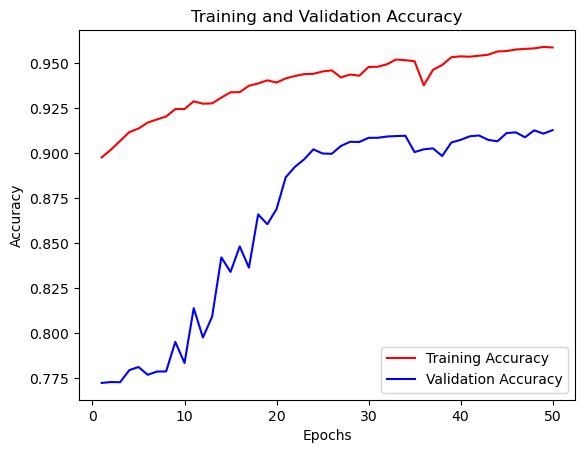

In [215]:
# Accessing training and testing accuracy
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

epochs = range(1, epochs + 1)

# Plotting
plt.plot(epochs, train_accuracy, 'r', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

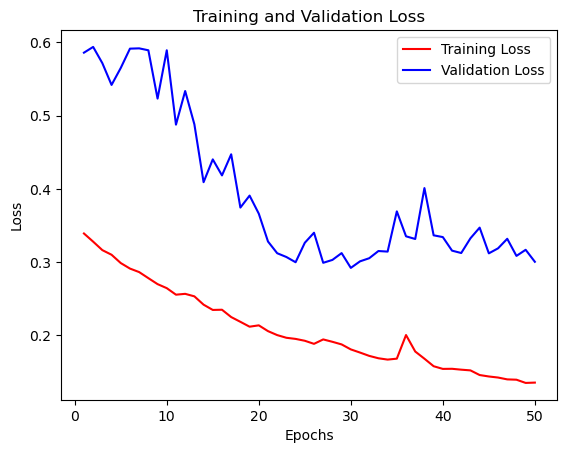

In [216]:
# Accessing training and testing accuracy
train_loss = history.history['loss']
val_Loss = history.history['val_loss']

epochs = range(1, 50 + 1)

# Plotting
plt.plot(epochs, train_loss, 'r', label='Training Loss')
plt.plot(epochs, val_Loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [217]:
model.save('models/roads_extraction.h5')

In [218]:
from submission_to_mask import reconstruct_from_labels

In [219]:
def extract_number(filename):
    return int(filename.split('_')[1].split('.')[0])
directory = os.listdir('test_set_images\\')
images_test = []
for i in directory:
    images_test.append(i)
    
sorted_images = sorted(images_test, key=extract_number)
test_iamges = np.array(sorted_images)    


In [220]:
test_iamges

array(['test_1.png', 'test_2.png', 'test_3.png', 'test_4.png',
       'test_5.png', 'test_6.png', 'test_7.png', 'test_8.png',
       'test_9.png', 'test_10.png', 'test_11.png', 'test_12.png',
       'test_13.png', 'test_14.png', 'test_15.png', 'test_16.png',
       'test_17.png', 'test_18.png', 'test_19.png', 'test_20.png',
       'test_21.png', 'test_22.png', 'test_23.png', 'test_24.png',
       'test_25.png', 'test_26.png', 'test_27.png', 'test_28.png',
       'test_29.png', 'test_30.png', 'test_31.png', 'test_32.png',
       'test_33.png', 'test_34.png', 'test_35.png', 'test_36.png',
       'test_37.png', 'test_38.png', 'test_39.png', 'test_40.png',
       'test_41.png', 'test_42.png', 'test_43.png', 'test_44.png',
       'test_45.png', 'test_46.png', 'test_47.png', 'test_48.png',
       'test_49.png', 'test_50.png'], dtype='<U11')

In [221]:
def preprocess_data(root_path, images, input_size):

    image = []
    for img_file in images:
        img = load_img(root_path + img_file, target_size=input_size, color_mode='rgb')
       
        # Convert image and mask to arrays
        img_array = img_to_array(img)
        img_array = img_array / 255.0

       

        # Append images and masks to the lists
        image.append(img_array)
        

        

    # Convert lists to numpy arrays
    images = np.array(image)
  

    return images


In [223]:
test = preprocess_data('test_set_images\\', test_iamges, input_size=INPUT_SIZE)
test

array([[[[0.19607843, 0.1764706 , 0.16470589],
         [0.22352941, 0.19607843, 0.18039216],
         [0.14901961, 0.14117648, 0.13725491],
         ...,
         [0.5529412 , 0.5294118 , 0.48235294],
         [0.06666667, 0.05882353, 0.05490196],
         [0.5568628 , 0.5372549 , 0.5019608 ]],

        [[0.21568628, 0.1882353 , 0.17254902],
         [0.21960784, 0.19607843, 0.18431373],
         [0.11764706, 0.11372549, 0.10588235],
         ...,
         [0.52156866, 0.49019608, 0.44313726],
         [0.5137255 , 0.4862745 , 0.44705883],
         [0.54901963, 0.5176471 , 0.47058824]],

        [[0.22745098, 0.21568628, 0.19607843],
         [0.21960784, 0.20784314, 0.19215687],
         [0.19607843, 0.18431373, 0.16862746],
         ...,
         [0.6117647 , 0.58431375, 0.5372549 ],
         [0.6862745 , 0.6627451 , 0.60784316],
         [0.48235294, 0.45490196, 0.40784314]],

        ...,

        [[0.5058824 , 0.4862745 , 0.4392157 ],
         [0.45882353, 0.43529412, 0.3882353 ]

In [224]:
prediction = model.predict(test)
prediction


2/2 [==============================] - 2s 517ms/step


array([[[[0.37860677],
         [0.23395285],
         [0.15094687],
         ...,
         [0.41934606],
         [0.2732304 ],
         [0.37643856]],

        [[0.2213609 ],
         [0.07966595],
         [0.10429171],
         ...,
         [0.39623892],
         [0.23014311],
         [0.24951895]],

        [[0.21963568],
         [0.11338907],
         [0.09867649],
         ...,
         [0.3823965 ],
         [0.33974516],
         [0.35089612]],

        ...,

        [[0.64143604],
         [0.74318737],
         [0.85159504],
         ...,
         [0.2088542 ],
         [0.1775963 ],
         [0.23103403]],

        [[0.45300838],
         [0.5811321 ],
         [0.7215558 ],
         ...,
         [0.18373166],
         [0.14561729],
         [0.23281561]],

        [[0.5009485 ],
         [0.53792953],
         [0.6452913 ],
         ...,
         [0.22254153],
         [0.2579578 ],
         [0.4250132 ]]],


       [[[0.63911766],
         [0.6291491 ],
         [0.73

In [226]:
import numpy as np
import cv2
import os
from PIL import Image

# Directory where you want to save the mask images
output_masks_directory = "test_set_masks"

# Ensure output directory exists
if not os.path.exists(output_masks_directory):
    os.makedirs(output_masks_directory)

# Loop through each image in the batch
for i, prediction in enumerate(predictions):
    if prediction.ndim == 3:  # (height, width, 1)
        prediction = np.squeeze(prediction, axis=-1) 

    # Apply threshold to convert probabilities to binary (0 or 1)
    mask = (prediction > 0.5).astype(np.uint8)

    # Create the mask image (black for roads, white for background)
    masked_image = np.zeros((mask.shape[0], mask.shape[1], 3), dtype=np.uint8)
    masked_image[mask == 1] = [0, 0, 0]  # black for road pixels
    masked_image[mask == 0] = [255, 255, 255]  # white for background pixels

    # Save the generated mask image
    output_mask_path = os.path.join(output_masks_directory, f"mask_{i+1}.png")
    cv2.imwrite(output_mask_path, masked_image)


print("Masks generated and saved successfully for all images.")


Masks generated and saved successfully for all images.


In [110]:
#!/usr/bin/env python3

import os
import numpy as np
import matplotlib.image as mpimg
import re

# percentage of pixels > 1 required to assign a foreground label to a patch
foreground_threshold = 0.25

# assign a label to a patch


def patch_to_label(patch):
    df = np.mean(patch)
    if df > foreground_threshold:
        return 1
    else:
        return 0


def mask_to_submission_strings(full_path, image_filename):
    """Reads a single image and outputs the strings that should go into the submission file"""
    img_number = int(re.search(r"\d+", image_filename).group(0))
    im = mpimg.imread(full_path)
    patch_size = 16
    for j in range(0, im.shape[1], patch_size):
        for i in range(0, im.shape[0], patch_size):
            patch = im[i:i + patch_size, j:j + patch_size]
            label = patch_to_label(patch)
            yield("{:03d}{}{},{}".format(img_number, j, i, label))


def masks_to_submission(submission_filename, submission_mask_path, image_filenames):
    """Converts images into a submission file"""
    with open(submission_filename, 'w') as f:
        f.write('id,prediction\n')
        for fn in image_filenames[0:]:
            path = os.path.join(submission_mask_path, fn)
            f.writelines('{}\n'.format(s)
                         for s in mask_to_submission_strings(path, fn))


def submit():
    submission_filename = 'h.csv'
    submission_mask_path = 'submits/file/'
    end = int(len('_mask.png'))
    start = int(len('test_'))
    image_names = os.listdir(submission_mask_path)
    image_names.sort(key=lambda x: int(x[start:][:-end]))
    masks_to_submission(submission_filename, submission_mask_path, image_names)

In [112]:
from tensorflow.keras.models import load_model
# load the saved model due to prior interuption
model = load_model('models/roads_extraction.h5')

In [ ]:
# display 10 random predictions
#random_indices = random.sample(range(0, len(test_images)), 10)
#test_sample = test_images[random_indices]

#predictions = model.predict(test_sample)
predictions = (predictions > 0.5).astype(np.uint8)

fig, axes = plt.subplots(10, 4, figsize=(10, 3*10))

# Iterate over the image and mask pairs and display them in subplots
for i in range(len(test)):

    image = (test[i] * 255).astype(np.uint8)
    mask = predictions[i]
    ground_truth = test_masks[random_indices][i] * np.array([255, 255, 255]) # convert the forground into yellow color to achieve the desired aesthetic

    overlay = image.copy()

    mask = np.repeat(mask, 3, axis=2) # matching the size of the channel of the mask and the image to perform an overlay
    inverted_mask = 1 - mask

    yellow_mask = np.array([255, 255, 255]) * mask

    # Apply the mask on the image
    result = image * inverted_mask + yellow_mask
    alpha = 0.2
    predicted_overlay = cv2.addWeighted(overlay, alpha, result.astype(overlay.dtype), 1 - alpha, 0)

    # Plot the image and mask in the corresponding subplot
    axes[i, 0].imshow(image)
    axes[i, 0].set_title('Original')
    axes[i, 0].axis('off')
    
    axes[i, 1].imshow(ground_truth)
    axes[i, 1].set_title('Ground Truth')
    axes[i, 1].axis('off')
    
    axes[i, 2].imshow(yellow_mask)
    axes[i, 2].set_title('Predicted')
    axes[i, 2].axis('off')
    
    axes[i, 3].imshow(predicted_overlay)
    axes[i, 3].set_title('Predicted Overlay')
    axes[i, 3].axis('off')
    
# Adjust the spacing between subplots
plt.tight_layout()
plt.savefig('result.png', bbox_inches='tight')  # Save as PNG image

# Show the plot
plt.show()
# save the output

